# 올림픽 메달 수 예측하기

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns

## 데이터 불러오기

In [66]:
summer = pd.read_csv("../project/data/summer.csv")
winter = pd.read_csv("../project/data/winter.csv")

In [67]:
summer.tail()

,Year,City,Sport,Discipline,Athlete,Country,Gender,Event,Medal
31160,2012,London,Wrestling,Wrestling Freestyle,"JANIKOWSKI, Damian",POL,Men,Wg 84 KG,Bronze
31161,2012,London,Wrestling,Wrestling Freestyle,"REZAEI, Ghasem Gholamreza",IRI,Men,Wg 96 KG,Gold
31162,2012,London,Wrestling,Wrestling Freestyle,"TOTROV, Rustam",RUS,Men,Wg 96 KG,Silver
31163,2012,London,Wrestling,Wrestling Freestyle,"ALEKSANYAN, Artur",ARM,Men,Wg 96 KG,Bronze
31164,2012,London,Wrestling,Wrestling Freestyle,"LIDBERG, Jimmy",SWE,Men,Wg 96 KG,Bronze


## 데이터 기본 분석
### 데이터 전처리

#### 1994년 이후 데이터로 축소하기
- 여러 국가들의 국정상태에 따라서 참가국형태가 상이한데 비해(분리국가, 통일국가 등) 1994년 올림픽 참가국들이 현재 올림픽 참가국들과 일치함.
   - ex) 구소련, 동독과 서독, 중국과 대만, 체코와 슬로바키아 등
   - https://en.wikipedia.org/wiki/All-time_Olympic_Games_medal_table 

In [72]:
summer = summer[summer.Year >= 1994].reset_index().drop("index", axis = 1)
summer = summer.rename(columns = {"Country":"Code"})
summer.head(1)

,Year,City,Sport,Discipline,Athlete,Code,Gender,Event,Medal
0,1996,Atlanta,Aquatics,Diving,"XIAO, Hailiang",CHN,Men,10M Platform,Bronze


#### Null 값 확인하기

In [73]:
summer.isnull().sum()

Year          0
City          0
Sport         0
Discipline    0
Athlete       0
Code          4
Gender        0
Event         0
Medal         0
dtype: int64

In [74]:
summer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9863 entries, 0 to 9862
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        9863 non-null   int64 
 1   City        9863 non-null   object
 2   Sport       9863 non-null   object
 3   Discipline  9863 non-null   object
 4   Athlete     9863 non-null   object
 5   Code        9859 non-null   object
 6   Gender      9863 non-null   object
 7   Event       9863 non-null   object
 8   Medal       9863 non-null   object
dtypes: int64(1), object(8)
memory usage: 693.6+ KB


#### top30로 축소하기
- 30위 범위 밖에 위치한 국가들은 매회마다 저조한 성적을 기록함으로 분석 범위를 30위권으로 좁히기로 하였다.

In [75]:
summer_top30_index = summer.groupby("Code")["Medal"].count().sort_values(ascending = False).head(30).index
summer_top30_index

Index(['USA', 'RUS', 'AUS', 'CHN', 'GER', 'NED', 'ITA', 'GBR', 'KOR', 'FRA',
       'JPN', 'BRA', 'ESP', 'CUB', 'CAN', 'HUN', 'UKR', 'ROU', 'ARG', 'NOR',
       'BLR', 'DEN', 'SWE', 'CRO', 'JAM', 'POL', 'GRE', 'NGR', 'NZL', 'BUL'],
      dtype='object', name='Code')

In [76]:
summer = summer[summer.Code.isin(summer_top30_index)].copy()
summer

,Year,City,Sport,Discipline,Athlete,Code,Gender,Event,Medal
0,1996,Atlanta,Aquatics,Diving,"XIAO, Hailiang",CHN,Men,10M Platform,Bronze
1,1996,Atlanta,Aquatics,Diving,"SAUTIN, Dmitry",RUS,Men,10M Platform,Gold
2,1996,Atlanta,Aquatics,Diving,"HEMPEL, Jan",GER,Men,10M Platform,Silver
3,1996,Atlanta,Aquatics,Diving,"CLARK, Mary Ellen",USA,Women,10M Platform,Bronze
4,1996,Atlanta,Aquatics,Diving,"FU, Mingxia",CHN,Women,10M Platform,Gold
...,...,...,...,...,...,...,...,...,...
9851,2012,London,Wrestling,Wrestling Freestyle,"VLASOV, Roman",RUS,Men,Wg 74 KG,Gold
9855,2012,London,Wrestling,Wrestling Freestyle,"KHUGAEV, Alan",RUS,Men,Wg 84 KG,Gold
9858,2012,London,Wrestling,Wrestling Freestyle,"JANIKOWSKI, Damian",POL,Men,Wg 84 KG,Bronze
9860,2012,London,Wrestling,Wrestling Freestyle,"TOTROV, Rustam",RUS,Men,Wg 96 KG,Silver


In [77]:
summer.isnull().sum()

Year          0
City          0
Sport         0
Discipline    0
Athlete       0
Code          0
Gender        0
Event         0
Medal         0
dtype: int64

#### 개최국 표시하기

In [78]:
host = {"City": ["Athens", "Atlanta", "Beijing", "London", "Sydney"],
             "HostCountry": ["Greece", "United States", "China", "United Kingdom", "Australia"]}
host = pd.DataFrame(data = host)
host

,City,HostCountry
0,Athens,Greece
1,Atlanta,United States
2,Beijing,China
3,London,United Kingdom
4,Sydney,Australia


In [79]:
summer = summer.merge(host, left_on = "City", right_on = "City").copy()
summer

,Year,City,Sport,Discipline,Athlete,Code,Gender,Event,Medal,HostCountry
0,1996,Atlanta,Aquatics,Diving,"XIAO, Hailiang",CHN,Men,10M Platform,Bronze,United States
1,1996,Atlanta,Aquatics,Diving,"SAUTIN, Dmitry",RUS,Men,10M Platform,Gold,United States
2,1996,Atlanta,Aquatics,Diving,"HEMPEL, Jan",GER,Men,10M Platform,Silver,United States
3,1996,Atlanta,Aquatics,Diving,"CLARK, Mary Ellen",USA,Women,10M Platform,Bronze,United States
4,1996,Atlanta,Aquatics,Diving,"FU, Mingxia",CHN,Women,10M Platform,Gold,United States
...,...,...,...,...,...,...,...,...,...,...
8696,2012,London,Wrestling,Wrestling Freestyle,"VLASOV, Roman",RUS,Men,Wg 74 KG,Gold,United Kingdom
8697,2012,London,Wrestling,Wrestling Freestyle,"KHUGAEV, Alan",RUS,Men,Wg 84 KG,Gold,United Kingdom
8698,2012,London,Wrestling,Wrestling Freestyle,"JANIKOWSKI, Damian",POL,Men,Wg 84 KG,Bronze,United Kingdom
8699,2012,London,Wrestling,Wrestling Freestyle,"TOTROV, Rustam",RUS,Men,Wg 96 KG,Silver,United Kingdom


#### 단체스포츠 중복 메달 수 제거하기

In [80]:
summer["Sport"].unique()

array(['Aquatics', 'Archery', 'Athletics', 'Badminton', 'Baseball',
       'Basketball', 'Boxing', 'Canoe / Kayak', 'Cycling', 'Equestrian',
       'Fencing', 'Football', 'Gymnastics', 'Handball', 'Hockey', 'Judo',
       'Modern Pentathlon', 'Rowing', 'Sailing', 'Shooting', 'Softball',
       'Table Tennis', 'Tennis', 'Volleyball', 'Weightlifting',
       'Wrestling', 'Taekwondo', 'Triathlon', 'Canoe'], dtype=object)

In [81]:
summer["Event"].unique()

array(['10M Platform', '3M Springboard', '100M Backstroke',
       '100M Breaststroke', '100M Butterfly', '100M Freestyle',
       '1500M Freestyle', '200M Backstroke', '200M Breaststroke',
       '200M Butterfly', '200M Freestyle', '200M Individual Medley',
       '400M Freestyle', '400M Individual Medley',
       '4X100M Freestyle Relay', '4X100M Medley Relay',
       '4X200M Freestyle Relay', '50M Freestyle', '800M Freestyle',
       'Team', 'Water Polo', 'Individual (Fita Olympic Round - 70M)',
       'Team (Fita Olympic Round - 70M)', '10000M', '10000M Walk', '100M',
       '100M Hurdles', '110M Hurdles', '1500M', '200M', '20KM Walk',
       '3000M Steeplechase', '400M', '400M Hurdles', '4X100M Relay',
       '4X400M Relay', '5000M', '50KM Walk', '800M', 'Decathlon',
       'Discus Throw', 'Hammer Throw', 'Heptathlon', 'High Jump',
       'Javelin Throw', 'Long Jump', 'Marathon', 'Pole Vault', 'Shot Put',
       'Triple Jump', 'Doubles', 'Singles', 'Baseball', 'Basketball',
      

In [82]:
summer = summer.drop(["Athlete"], axis = 1)
summer = summer.drop_duplicates()
summer

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States
1,1996,Atlanta,Aquatics,Diving,RUS,Men,10M Platform,Gold,United States
2,1996,Atlanta,Aquatics,Diving,GER,Men,10M Platform,Silver,United States
3,1996,Atlanta,Aquatics,Diving,USA,Women,10M Platform,Bronze,United States
4,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States
...,...,...,...,...,...,...,...,...,...
8696,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 74 KG,Gold,United Kingdom
8697,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 84 KG,Gold,United Kingdom
8698,2012,London,Wrestling,Wrestling Freestyle,POL,Men,Wg 84 KG,Bronze,United Kingdom
8699,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 96 KG,Silver,United Kingdom


### 예상 변수 데이터들 합치기
#### GDP데이터
> https://www.kaggle.com/greeshmagirish/worldbank-data-on-gdp-population-and-military?select=API_NY.GDP.MKTP.CD_DS2_en_csv_v2_559588.csv

In [83]:
gdp = pd.read_csv("../project/data/gdp.csv")
gdp = gdp[["Country Name", "Country Code", "1996", "2000", "2004", "2008", "2012"]]#.set_index(["Country Name","Country Code"])
gdp = gdp.rename(columns = {"Country Name" : "Country", "Country Code" : "Code"})
gdp.head()

,Country,Code,1996,2000,2004,2008,2012
0,Aruba,ABW,1.379961e+09,1.873453e+09,2.228492e+09,2.745251e+09,2.534637e+09
1,Afghanistan,AFG,NaN,NaN,5.226775e+09,1.010922e+10,2.000162e+10
2,Angola,AGO,7.526447e+09,9.129595e+09,2.355205e+10,8.853861e+10,1.280529e+11
3,Albania,ALB,3.199643e+09,3.480355e+09,7.184681e+09,1.288135e+10,1.231978e+10
4,Andorra,AND,1.223945e+09,1.434430e+09,2.935659e+09,4.007353e+09,3.164615e+09


In [84]:
summertop30 = ['USA', 'RUS', 'AUS', 'CHN', 'GER', 'NED', 'ITA', 'GBR', 'KOR', 'FRA',
       'JPN', 'BRA', 'ESP', 'CUB', 'CAN', 'HUN', 'UKR', 'ROU', 'ARG', 'NOR',
       'BLR', 'DEN', 'SWE', 'CRO', 'JAM', 'POL', 'GRE', 'NGR', 'NZL', 'BUL']

In [85]:
"|".join(summertop30)

'USA|RUS|AUS|CHN|GER|NED|ITA|GBR|KOR|FRA|JPN|BRA|ESP|CUB|CAN|HUN|UKR|ROU|ARG|NOR|BLR|DEN|SWE|CRO|JAM|POL|GRE|NGR|NZL|BUL'

In [86]:
gdp = gdp.melt(id_vars = ["Code", "Country"], value_vars = ["1996", "2000", "2004", "2008", "2012"],
          var_name = 'Year', value_name = 'GDP').sort_values(by = ["Code", "Year"]).reset_index(drop = True)
gdp.Year = gdp.Year.astype(int)
gdp.head()

,Code,Country,Year,GDP
0,ABW,Aruba,1996,1.379961e+09
1,ABW,Aruba,2000,1.873453e+09
2,ABW,Aruba,2004,2.228492e+09
3,ABW,Aruba,2008,2.745251e+09
4,ABW,Aruba,2012,2.534637e+09


In [87]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Code     1320 non-null   object 
 1   Country  1320 non-null   object 
 2   Year     1320 non-null   int32  
 3   GDP      1233 non-null   float64
dtypes: float64(1), int32(1), object(2)
memory usage: 36.2+ KB


In [40]:
# summer_gdp = pd.merge(left = summer, right = gdp, how = "left",
#                       left_on = ["Year", "Code"],right_on = ["Year", "Code"]).copy()
# summer_gdp

,Year,City,Sport,Discipline,Athlete,Code,Gender,Event,Medal,HostCountry,Country,GDP
0,1996,Atlanta,Aquatics,Diving,"XIAO, Hailiang",CHN,Men,10M Platform,Bronze,United States,China,8.637467e+11
1,1996,Atlanta,Aquatics,Diving,"SAUTIN, Dmitry",RUS,Men,10M Platform,Gold,United States,Russian Federation,3.917249e+11
2,1996,Atlanta,Aquatics,Diving,"HEMPEL, Jan",GER,Men,10M Platform,Silver,United States,NaN,NaN
3,1996,Atlanta,Aquatics,Diving,"CLARK, Mary Ellen",USA,Women,10M Platform,Bronze,United States,United States,8.073122e+12
4,1996,Atlanta,Aquatics,Diving,"FU, Mingxia",CHN,Women,10M Platform,Gold,United States,China,8.637467e+11
...,...,...,...,...,...,...,...,...,...,...,...,...
8695,2012,London,Wrestling,Wrestling Freestyle,"VLASOV, Roman",RUS,Men,Wg 74 KG,Gold,United Kingdom,Russian Federation,2.210257e+12
8696,2012,London,Wrestling,Wrestling Freestyle,"KHUGAEV, Alan",RUS,Men,Wg 84 KG,Gold,United Kingdom,Russian Federation,2.210257e+12
8697,2012,London,Wrestling,Wrestling Freestyle,"JANIKOWSKI, Damian",POL,Men,Wg 84 KG,Bronze,United Kingdom,Poland,5.003608e+11
8698,2012,London,Wrestling,Wrestling Freestyle,"TOTROV, Rustam",RUS,Men,Wg 96 KG,Silver,United Kingdom,Russian Federation,2.210257e+12


In [56]:
# summer_gdp.isnull().sum()

Year              0
City              0
Sport             0
Discipline        0
Athlete           0
Code              0
Gender            0
Event             0
Medal             0
HostCountry       0
Country        1348
GDP            1348
dtype: int64

In [45]:
# summer_gdp.loc[summer_gdp.GDP.isnull() == True].groupby(["Code", "Year"])["GDP"].count()

Code  Year
BUL   1996    0
      2000    0
      2004    0
      2008    0
      2012    0
CRO   1996    0
      2000    0
      2004    0
      2008    0
      2012    0
DEN   1996    0
      2000    0
      2004    0
      2008    0
      2012    0
GER   1996    0
      2000    0
      2004    0
      2008    0
      2012    0
GRE   1996    0
      2000    0
      2004    0
      2008    0
      2012    0
NED   1996    0
      2000    0
      2004    0
      2008    0
      2012    0
NGR   1996    0
      2000    0
      2004    0
      2008    0
Name: GDP, dtype: int64

In [88]:
gdp.head()

,Code,Country,Year,GDP
0,ABW,Aruba,1996,1.379961e+09
1,ABW,Aruba,2000,1.873453e+09
2,ABW,Aruba,2004,2.228492e+09
3,ABW,Aruba,2008,2.745251e+09
4,ABW,Aruba,2012,2.534637e+09


In [89]:
gdp.loc[gdp.Country == "Nigeria"]

,Code,Country,Year,GDP
860,NGA,Nigeria,1996,5.107582e+10
861,NGA,Nigeria,2000,6.944876e+10
862,NGA,Nigeria,2004,1.363860e+11
863,NGA,Nigeria,2008,3.370355e+11
864,NGA,Nigeria,2012,4.593760e+11


In [90]:
gdp.loc[gdp.Country == "Greece"]

,Code,Country,Year,GDP
435,GRC,Greece,1996,1.458616e+11
436,GRC,Greece,2000,1.301338e+11
437,GRC,Greece,2004,2.405213e+11
438,GRC,Greece,2008,3.544608e+11
439,GRC,Greece,2012,2.456707e+11


In [91]:
gdp.Code = gdp.Code.str.replace("DEU", "GER")
gdp.Code = gdp.Code.str.replace("BGR", "BUL")
gdp.Code = gdp.Code.str.replace("HRV", "CRO")
gdp.Code = gdp.Code.str.replace("DNK", "DEN")
gdp.Code = gdp.Code.str.replace("GRC", "GRE")
gdp.Code = gdp.Code.str.replace("NLD", "NED")
gdp.Code = gdp.Code.str.replace("NGA", "NGR")

In [92]:
summer_gdp = pd.merge(left = summer, right = gdp, how = "left",
                      left_on = ["Year", "Code"],right_on = ["Year", "Code"]).copy()
summer_gdp

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,GDP
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States,China,8.637467e+11
1,1996,Atlanta,Aquatics,Diving,RUS,Men,10M Platform,Gold,United States,Russian Federation,3.917249e+11
2,1996,Atlanta,Aquatics,Diving,GER,Men,10M Platform,Silver,United States,Germany,2.503665e+12
3,1996,Atlanta,Aquatics,Diving,USA,Women,10M Platform,Bronze,United States,United States,8.073122e+12
4,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States,China,8.637467e+11
...,...,...,...,...,...,...,...,...,...,...,...
3791,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 74 KG,Gold,United Kingdom,Russian Federation,2.210257e+12
3792,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 84 KG,Gold,United Kingdom,Russian Federation,2.210257e+12
3793,2012,London,Wrestling,Wrestling Freestyle,POL,Men,Wg 84 KG,Bronze,United Kingdom,Poland,5.003608e+11
3794,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 96 KG,Silver,United Kingdom,Russian Federation,2.210257e+12


In [93]:
summer_gdp.isnull().sum()

Year           0
City           0
Sport          0
Discipline     0
Code           0
Gender         0
Event          0
Medal          0
HostCountry    0
Country        0
GDP            0
dtype: int64

#### 인구데이터 합치기
> https://datahub.io/JohnSnowLabs/population-figures-by-country

In [94]:
pop = pd.read_csv("../project/data/population-figures-by-country-csv_csv.csv")
pop = pop[["Country", "Country_Code", "Year_1996", "Year_2000", "Year_2004", "Year_2008", "Year_2012"]]
pop.columns = ["Country", "Code", "1996", "2000", "2004", "2008", "2012"]
pop

,Country,Code,1996,2000,2004,2008,2012
0,Aruba,ABW,83200.0,90853,98737.00,101353.0,102577.00
1,Afghanistan,AFG,17822884.0,20093756,24118979.00,27294031.0,30696958.00
2,Angola,AGO,14682284.0,16440924,18865716.00,21759420.0,25096150.00
3,Albania,ALB,3168033.0,3089027,3026939.00,2947314.0,2900401.00
4,Andorra,AND,64360.0,65390,76244.00,83861.0,82431.00
...,...,...,...,...,...,...,...
258,Kosovo,XKX,2059000.0,1700000,1704622.00,1747383.0,1805200.00
259,"Yemen, Rep.",YEM,15889449.0,17874725,20017068.00,22356391.0,24909969.00
260,South Africa,ZAF,42210216.0,44896856,47001700.99,49557573.3,52506515.08
261,Zambia,ZMB,9394304.0,10531221,11731746.00,13082517.0,14699937.00


In [95]:
pop.loc[pop.Country == "Croatia"]

,Country,Code,1996,2000,2004,2008,2012
97,Croatia,HRV,4494000.0,4426000,4439000.0,4434508.0,4267558.0


In [96]:
pop_melt = pop.melt(id_vars = ["Code"], value_vars = ["1996", "2000", "2004", "2008", "2012"],
          var_name = 'Year', value_name = 'Population').sort_values(by = ["Code", "Year"]).reset_index(drop = True)
pop_melt.Year = pop_melt.Year.astype(int)
pop_melt.head()

,Code,Year,Population
0,ABW,1996,83200.0
1,ABW,2000,90853.0
2,ABW,2004,98737.0
3,ABW,2008,101353.0
4,ABW,2012,102577.0


In [97]:
pop_melt.Code = pop_melt.Code.str.replace("DEU", "GER")
pop_melt.Code = pop_melt.Code.str.replace("BGR", "BUL")
pop_melt.Code = pop_melt.Code.str.replace("HRV", "CRO")
pop_melt.Code = pop_melt.Code.str.replace("DNK", "DEN")
pop_melt.Code = pop_melt.Code.str.replace("GRC", "GRE")
pop_melt.Code = pop_melt.Code.str.replace("NLD", "NED")
pop_melt.Code = pop_melt.Code.str.replace("NGA", "NGR")

In [119]:
summer_gdp_pop = pd.merge(left = summer_gdp, right = pop_melt, how = "left", left_on = ["Year", "Code"], right_on = ["Year", "Code"]).copy()
summer_gdp_pop

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,GDP,Population
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States,China,8.637467e+11,1.217550e+09
1,1996,Atlanta,Aquatics,Diving,RUS,Men,10M Platform,Gold,United States,Russian Federation,3.917249e+11,1.481600e+08
2,1996,Atlanta,Aquatics,Diving,GER,Men,10M Platform,Silver,United States,Germany,2.503665e+12,8.191483e+07
3,1996,Atlanta,Aquatics,Diving,USA,Women,10M Platform,Bronze,United States,United States,8.073122e+12,2.693940e+08
4,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States,China,8.637467e+11,1.217550e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
3791,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 74 KG,Gold,United Kingdom,Russian Federation,2.210257e+12,1.432017e+08
3792,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 84 KG,Gold,United Kingdom,Russian Federation,2.210257e+12,1.432017e+08
3793,2012,London,Wrestling,Wrestling Freestyle,POL,Men,Wg 84 KG,Bronze,United Kingdom,Poland,5.003608e+11,3.806316e+07
3794,2012,London,Wrestling,Wrestling Freestyle,RUS,Men,Wg 96 KG,Silver,United Kingdom,Russian Federation,2.210257e+12,1.432017e+08


In [140]:
summer_gdp_pop.isnull().sum()

Year           0
City           0
Sport          0
Discipline     0
Code           0
Gender         0
Event          0
Medal          0
HostCountry    0
Country        0
GDP            0
Population     0
HostMonth      0
dtype: int64

In [190]:
countries[countries.isin(countrylist) == False]

17    Korea, Rep.
dtype: object

#### 기온데이터 합치기
> https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [200]:
countries = summer_gdp_pop["Country"].unique()
countries
# countries.str.replace(", ", "|")

array(['China', 'Russian Federation', 'Germany', 'United States',
       'Canada', 'Cuba', 'Australia', 'Brazil', 'United Kingdom', 'Italy',
       'Hungary', 'New Zealand', 'Netherlands', 'Sweden', 'Japan',
       'Spain', 'Croatia', 'Korea, Rep.', 'Ukraine', 'Poland', 'Jamaica',
       'France', 'Romania', 'Nigeria', 'Norway', 'Belarus', 'Bulgaria',
       'Greece', 'Denmark', 'Argentina'], dtype=object)

In [201]:
type(countries)

numpy.ndarray

In [202]:
countries = pd.Series(countries)
type(countries)

pandas.core.series.Series

In [203]:
temp2 = pd.read_csv("../project/data/GlobalLandTemperaturesByCountry.csv")
temp2 = temp2.loc[(temp2.dt > "1996-06-01") & (temp2.dt < "2012-10-01")].copy()
temp2 = temp2.loc[temp2.dt.str.contains("1996|2000|2004|2008|2012")]
temp2 = temp2.loc[temp2.dt.str.contains("-07|-08|-09")]
temp2.Country = temp2.Country.str.replace("South Korea", "Korea, Rep.")
temp2.Country = temp2.Country.str.replace("Russia", "Russian Federation")
temp2 = temp2.loc[temp2.Country.isin(countries)].drop(columns = "AverageTemperatureUncertainty", axis = 1)
temp2.columns = ["HostMonth", "CountryTemp", "Country"]
temp2.HostMonth = temp2.HostMonth.str.replace("-01", "")
temp2

,HostMonth,CountryTemp,Country
27160,1996-07,7.544,Argentina
27161,1996-08,11.684,Argentina
27162,1996-09,12.602,Argentina
27208,2000-07,6.306,Argentina
27209,2000-08,9.887,Argentina
...,...,...,...
557759,2008-08,20.543,United States
557760,2008-09,16.567,United States
557806,2012-07,23.008,United States
557807,2012-08,21.422,United States


In [204]:
temp2.Country.unique()

array(['Argentina', 'Australia', 'Belarus', 'Brazil', 'Bulgaria',
       'Canada', 'China', 'Croatia', 'Cuba', 'Denmark', 'France',
       'Germany', 'Greece', 'Hungary', 'Italy', 'Jamaica', 'Japan',
       'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Poland',
       'Romania', 'Russian Federation', 'Korea, Rep.', 'Spain', 'Sweden',
       'Ukraine', 'United Kingdom', 'United States'], dtype=object)

In [205]:
temp3 = pd.read_csv("../project/data/GlobalLandTemperaturesByCity.csv")
temp3 = temp3.loc[(temp3.dt > "1996-06-01") & (temp3.dt < "2012-10-01")].copy()
temp3 = temp3.loc[temp3.dt.str.contains("1996|2000|2004|2008|2012")]
temp3 = temp3.loc[temp3.dt.str.contains("-07|-08|-09")]
temp3.Country = temp3.Country.str.replace("South Korea", "Korea, Rep.")
temp3.Country = temp3.Country.str.replace("Russia", "Russian Federation")
temp3 = temp3.loc[temp3.Country.isin(countries)].drop(columns = "AverageTemperatureUncertainty", axis = 1)
temp3.columns = ["HostMonth", "HostCityTemp", "City", "HostCountry", "Latitude", "Longitude"]
temp3.HostMonth = temp3.HostMonth.str.replace("-01", "")
temp3

,HostMonth,HostCityTemp,City,HostCountry,Latitude,Longitude
3032,1996-07,15.684,Århus,Denmark,57.05N,10.33E
3033,1996-08,18.492,Århus,Denmark,57.05N,10.33E
3034,1996-09,12.039,Århus,Denmark,57.05N,10.33E
3080,2000-07,16.244,Århus,Denmark,57.05N,10.33E
3081,2000-08,15.917,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...
8599150,2008-08,17.597,Zwolle,Netherlands,52.24N,5.26E
8599151,2008-09,13.838,Zwolle,Netherlands,52.24N,5.26E
8599197,2012-07,17.329,Zwolle,Netherlands,52.24N,5.26E
8599198,2012-08,18.588,Zwolle,Netherlands,52.24N,5.26E


In [206]:
temp3.loc[temp3.City.str.contains("Beijing")]

,HostMonth,HostCityTemp,City,HostCountry,Latitude,Longitude


In [207]:
temp3.loc[temp3.HostCountry == "China"]["City"].unique()

array(['Ürümqi', 'Acheng', 'Aksu', 'Altay', 'Anbu', 'Anda', 'Ankang',
       'Anqing', 'Anqiu', 'Anshan', 'Anshun', 'Anyang', 'Badaojiang',
       'Baicheng', 'Baiyin', 'Bantou', 'Baoding', 'Baoji', 'Baoshan',
       'Beian', 'Beibei', 'Beihai', 'Beipiao', 'Bengbu', 'Benxi',
       'Binzhou', 'Boshan', 'Bozhou', 'Buhe', 'Cangzhou', 'Changchun',
       'Changde', 'Changji', 'Changzhou', 'Chaohu', 'Chaoyang',
       'Chaozhou', 'Chengde', 'Chengdu', 'Chenghai', 'Chenzhou',
       'Chifeng', 'Chizhou', 'Chongqing', 'Chuncheng', 'Chuzhou', 'Daan',
       'Dali', 'Dalian', 'Daliang', 'Dandong', 'Danshui', 'Datong',
       'Dawukou', 'Daxian', 'Dehui', 'Deyang', 'Dezhou', 'Didao',
       'Dingzhou', 'Donghai', 'Dongli', 'Dongling', 'Dongtai', 'Dongying',
       'Dunhua', 'Encheng', 'Ezhou', 'Fengcheng', 'Foshan', 'Fuling',
       'Fushun', 'Fuxin', 'Fuyang', 'Fuyu', 'Fuzhou', 'Ganzhou', 'Gaomi',
       'Gaozhou', 'Gejiu', 'Gongzhuling', 'Guangshui', 'Guangyuan',
       'Guangzhou', 'Guilin',

In [208]:
citytemp = temp3.loc[temp3.City.str.contains("Atlanta|Athens|Sydney|Peking|London")].copy()
citytemp.City.unique()

array(['Athens', 'Atlanta', 'London', 'Peking', 'Sydney'], dtype=object)

In [209]:
summer_gdp_pop.City.unique()

array(['Atlanta', 'Sydney', 'Athens', 'Beijing', 'London'], dtype=object)

In [210]:
citytemp.City = citytemp.City.str.replace("Peking", "Beijing")
citytemp

,HostMonth,HostCityTemp,City,HostCountry,Latitude,Longitude
463916,1996-07,26.017,Athens,Greece,37.78N,24.41E
463917,1996-08,26.045,Athens,Greece,37.78N,24.41E
463918,1996-09,22.608,Athens,Greece,37.78N,24.41E
463964,2000-07,27.716,Athens,Greece,37.78N,24.41E
463965,2000-08,26.578,Athens,Greece,37.78N,24.41E
...,...,...,...,...,...,...
7296165,2008-08,13.637,Sydney,Australia,34.56S,151.78E
7296166,2008-09,16.340,Sydney,Australia,34.56S,151.78E
7296212,2012-07,14.740,Sydney,Australia,34.56S,151.78E
7296213,2012-08,14.892,Sydney,Australia,34.56S,151.78E


In [211]:
hostcitytemp = citytemp.loc[((citytemp.City == "Athens") & (citytemp.HostMonth == "2004-08")) |
             ((citytemp.City == "Beijing") & (citytemp.HostMonth == "2008-08")) |
            ((citytemp.City == "Sydney") & (citytemp.HostMonth == "2000-09")) |
            ((citytemp.City == "Atlanta") & (citytemp.HostMonth == "1996-07")) |
            ((citytemp.City == "London") & (citytemp.HostMonth == "2012-07") & (citytemp.HostCountry == "United Kingdom"))]
hostcitytemp = hostcitytemp.reset_index(drop = True)
hostcitytemp.sort_values(by = "HostMonth")

,HostMonth,HostCityTemp,City,HostCountry,Latitude,Longitude
1,1996-07,24.538,Atlanta,United States,34.56N,83.68W
4,2000-09,16.932,Sydney,Australia,34.56S,151.78E
0,2004-08,26.556,Athens,Greece,37.78N,24.41E
3,2008-08,25.809,Beijing,China,39.38N,116.53E
2,2012-07,16.487,London,United Kingdom,52.24N,0.00W


In [212]:
summer_gdp_pop.loc[summer_gdp_pop.City == "Atlanta", "HostMonth"] = "1996-07"
summer_gdp_pop.loc[summer_gdp_pop.City == "Sydney", "HostMonth"] = "2000-09"
summer_gdp_pop.loc[summer_gdp_pop.City == "Athens", "HostMonth"] = "2004-08"
summer_gdp_pop.loc[summer_gdp_pop.City == "Beijing", "HostMonth"] = "2008-08"
summer_gdp_pop.loc[summer_gdp_pop.City == "London", "HostMonth"] = "2012-07"

In [531]:
summeroly = summer_gdp_pop.merge(hostcitytemp, left_on = ["City", "HostMonth", "HostCountry"],
                                  right_on = ["City", "HostMonth", "HostCountry"]).copy()

In [532]:
summeroly = summeroly.merge(temp2, left_on = ["HostMonth", "Country"], right_on = ["HostMonth", "Country"]).copy()
summeroly

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,GDP,Population,HostMonth,HostCityTemp,Latitude,Longitude,CountryTemp
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
1,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
2,1996,Atlanta,Aquatics,Diving,CHN,Men,3M Springboard,Gold,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
3,1996,Atlanta,Aquatics,Diving,CHN,Men,3M Springboard,Silver,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
4,1996,Atlanta,Aquatics,Diving,CHN,Women,3M Springboard,Gold,United States,China,8.637467e+11,1.217550e+09,1996-07,24.538,34.56N,83.68W,19.589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,2012,London,Sailing,Sailing,ARG,Men,470,Bronze,United Kingdom,Argentina,5.459824e+11,4.209674e+07,2012-07,16.487,52.24N,0.00W,6.980
3792,2012,London,Taekwondo,Taekwondo,ARG,Men,68 - 80 KG,Gold,United Kingdom,Argentina,5.459824e+11,4.209674e+07,2012-07,16.487,52.24N,0.00W,6.980
3793,2012,London,Tennis,Tennis,ARG,Men,Singles,Bronze,United Kingdom,Argentina,5.459824e+11,4.209674e+07,2012-07,16.487,52.24N,0.00W,6.980
3794,2012,London,Judo,Judo,GRE,Men,81 - 90KG,Bronze,United Kingdom,Greece,2.456707e+11,1.104501e+07,2012-07,16.487,52.24N,0.00W,27.565


In [217]:
summeroly.isnull().sum()

Year            0
City            0
Sport           0
Discipline      0
Code            0
Gender          0
Event           0
Medal           0
HostCountry     0
Country         0
GDP             0
Population      0
HostMonth       0
HostCityTemp    0
Latitude        0
Longitude       0
CountryTemp     0
dtype: int64

In [221]:
len(summeroly.Country.unique())

30

In [533]:
summeroly["TempDiff"] = summeroly.HostCityTemp - summeroly.CountryTemp

In [534]:
summeroly.sample()

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,GDP,Population,HostMonth,HostCityTemp,Latitude,Longitude,CountryTemp,TempDiff
1485,2004,Athens,Aquatics,Diving,CHN,Men,10M Platform,Gold,Greece,China,1.955347e+12,1.296075e+09,2004-08,26.556,37.78N,24.41E,18.757,7.799


#### 개최국 메달수 증감율

In [244]:
medals = summeroly.loc[summeroly.Year == 1996].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
medals = medals.rename(columns = {"Medal" : "Atlanta"})
medals

,Country,Atlanta
0,United States,104
1,Germany,66
2,Russian Federation,63
3,China,50
4,Australia,42
5,France,37
6,Italy,35
7,"Korea, Rep.",28
8,Cuba,25
9,Ukraine,23


In [245]:
sydney = summeroly.loc[summeroly.Year == 2000].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
sydney = sydney.rename(columns = {"Medal" : "Sydney"})
sydney

,Country,Sydney
0,United States,94
1,Russian Federation,89
2,Australia,58
3,China,58
4,Germany,56
5,France,38
6,Italy,34
7,United Kingdom,30
8,Cuba,29
9,"Korea, Rep.",28


In [246]:
Athens = summeroly.loc[summeroly.Year == 2004].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
Athens = Athens.rename(columns = {"Medal" : "Athens"})
Athens

,Country,Athens
0,United States,105
1,Russian Federation,92
2,China,63
3,Germany,50
4,Australia,49
5,Japan,37
6,France,33
7,United Kingdom,32
8,Italy,32
9,"Korea, Rep.",30


In [250]:
beijing = summeroly.loc[summeroly.Year == 2008].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
beijing = beijing.rename(columns = {"Medal" : "Beijing"})
beijing

,Country,Beijing
0,United States,111
1,China,100
2,Russian Federation,72
3,United Kingdom,48
4,Australia,47
5,Germany,42
6,France,41
7,"Korea, Rep.",32
8,Italy,27
9,Ukraine,27


In [251]:
london = summeroly.loc[summeroly.Year == 2012].groupby("Country")["Medal"].count().sort_values(ascending = False).reset_index()
london = london.rename(columns = {"Medal" : "London"})
london

,Country,London
0,United States,104
1,China,91
2,Russian Federation,72
3,United Kingdom,68
4,Germany,45
5,Japan,38
6,Australia,35
7,France,35
8,"Korea, Rep.",30
9,Italy,28


In [295]:
all_medals = pd.merge(medals, sydney, left_on = "Country", right_on = "Country")
all_medals = pd.merge(all_medals, Athens, left_on = "Country", right_on = "Country")
all_medals = pd.merge(all_medals, beijing, left_on = "Country", right_on = "Country")
all_medals = pd.merge(all_medals, london, left_on = "Country", right_on = "Country", how = "left")

all_medals.London = all_medals.London.fillna(0).astype(int)
all_medals
# all_medals.Sum = all_medals.Atlanta + all_medals.Sydney

,Country,Atlanta,Sydney,Athens,Beijing,London
0,United States,104,94,105,111,104
1,Germany,66,56,50,42,45
2,Russian Federation,63,89,92,72,72
3,China,50,58,63,100,91
4,Australia,42,58,49,47,35
5,France,37,38,33,41,35
6,Italy,35,34,32,27,28
7,"Korea, Rep.",28,28,30,32,30
8,Cuba,25,29,27,24,15
9,Ukraine,23,23,23,27,19


In [481]:
all_medals["Sum"] = all_medals.Atlanta + all_medals.Sydney + all_medals.Athens + all_medals.Beijing + all_medals.London
all_medals.style.background_gradient(cmap = "BuGn")

,Country,Atlanta,Sydney,Athens,Beijing,London,Sum
0,United States,104,94,105,111,104,518
1,Germany,66,56,50,42,45,259
2,Russian Federation,63,89,92,72,72,388
3,China,50,58,63,100,91,362
4,Australia,42,58,49,47,35,231
5,France,37,38,33,41,35,184
6,Italy,35,34,32,27,28,156
7,"Korea, Rep.",28,28,30,32,30,148
8,Cuba,25,29,27,24,15,120
9,Ukraine,23,23,23,27,19,115


In [362]:
import matplotlib.pyplot as plt
import matplotlib

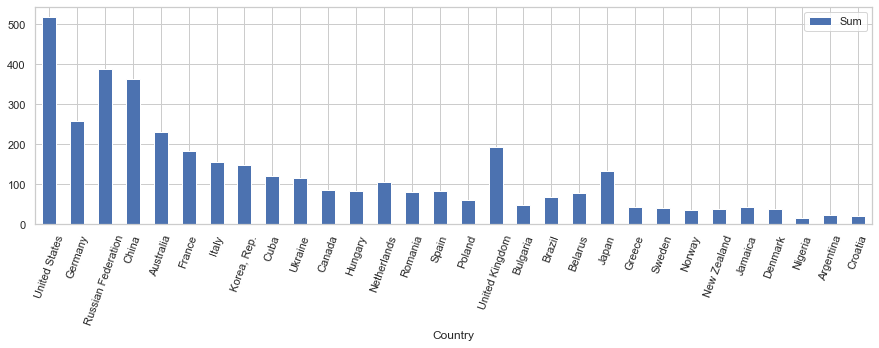

In [439]:
# sns.set_style("whitegrid")
# plt.figure(figsize = (20, 4))
# barplot = plt.bar(data = all_medals, x = "Country", height = "Sum", align = "edge")

all_medals.plot.bar(x = "Country", y = "Sum", figsize = (15, 4), rot = 70)

In [398]:
plt.rc("font", family = "Malgun Gothic")
plt.rc("axes", unicode_minus = False)

각 나라별 메달 현황 그래프그리기

#### 개최년도 1, 0으로 표시하기

In [573]:
summeroly["1996"] = pd.Series()
summeroly["2000"] = pd.Series()
summeroly["2004"] = pd.Series()
summeroly["2008"] = pd.Series()
summeroly["2012"] = pd.Series()

for x in range(3796):
    if summeroly["Year"][x] == 1996:
        summeroly["1996"][x] = 1
    elif summeroly["Year"][x] == 2000:
        summeroly["2000"][x] = 1
    elif summeroly["Year"][x] == 2004:
        summeroly["2004"][x] = 1
    elif summeroly["Year"][x] == 2008:
        summeroly["2008"][x] = 1
    elif summeroly["Year"][x] == 2012:
        summeroly["2012"][x] = 1
    else:
        fillna(0)
        

C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future ve

In [541]:
def host_year(x):
    if summeroly["Year"][x] == 1996 : 
        summeroly["1996"][x] = 1
    else:
        summeroly["1996"][x] = 0

In [536]:
summeroly["Year"][1000]

2000

In [556]:
if summeroly["Year"][0] == 1996 : 
        summeroly["1996"] = 1

In [567]:
summeroly = summeroly.drop(columns = ["1996", "2000", "2004", "2008", "2012"])

In [570]:
summeroly["1996"] = pd.Series()

C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [582]:
summeroly

,Year,City,Sport,Discipline,Code,Gender,Event,Medal,HostCountry,Country,...,HostCityTemp,Latitude,Longitude,CountryTemp,TempDiff,1996,2000,2004,2008,2012
0,1996,Atlanta,Aquatics,Diving,CHN,Men,10M Platform,Bronze,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,0,0,0,0
1,1996,Atlanta,Aquatics,Diving,CHN,Women,10M Platform,Gold,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,0,0,0,0
2,1996,Atlanta,Aquatics,Diving,CHN,Men,3M Springboard,Gold,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,0,0,0,0
3,1996,Atlanta,Aquatics,Diving,CHN,Men,3M Springboard,Silver,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,0,0,0,0
4,1996,Atlanta,Aquatics,Diving,CHN,Women,3M Springboard,Gold,United States,China,...,24.538,34.56N,83.68W,19.589,4.949,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,2012,London,Sailing,Sailing,ARG,Men,470,Bronze,United Kingdom,Argentina,...,16.487,52.24N,0.00W,6.980,9.507,0,0,0,0,1
3792,2012,London,Taekwondo,Taekwondo,ARG,Men,68 - 80 KG,Gold,United Kingdom,Argentina,...,16.487,52.24N,0.00W,6.980,9.507,0,0,0,0,1
3793,2012,London,Tennis,Tennis,ARG,Men,Singles,Bronze,United Kingdom,Argentina,...,16.487,52.24N,0.00W,6.980,9.507,0,0,0,0,1
3794,2012,London,Judo,Judo,GRE,Men,81 - 90KG,Bronze,United Kingdom,Greece,...,16.487,52.24N,0.00W,27.565,-11.078,0,0,0,0,1


In [576]:
summeroly[["1996", "2000", "2004", "2008", "2012"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 0 to 3795
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1996    716 non-null    float64
 1   2000    768 non-null    float64
 2   2004    771 non-null    float64
 3   2008    777 non-null    float64
 4   2012    764 non-null    float64
dtypes: float64(5)
memory usage: 337.9 KB


In [581]:
summeroly[["1996", "2000", "2004", "2008", "2012"]]= summeroly[["1996", "2000", "2004", "2008", "2012"]].fillna(0).astype(int)

### 변수 설정하기
#### 국가에 따른 메달수는?

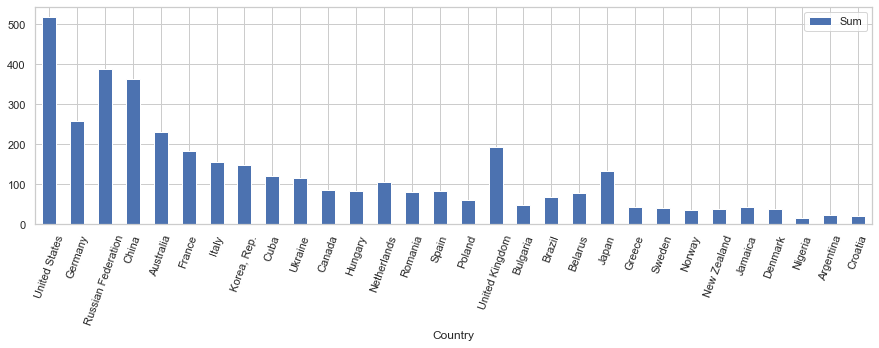

In [585]:
all_medals.plot.bar(x = "Country", y = "Sum", figsize = (15, 4), rot = 70)

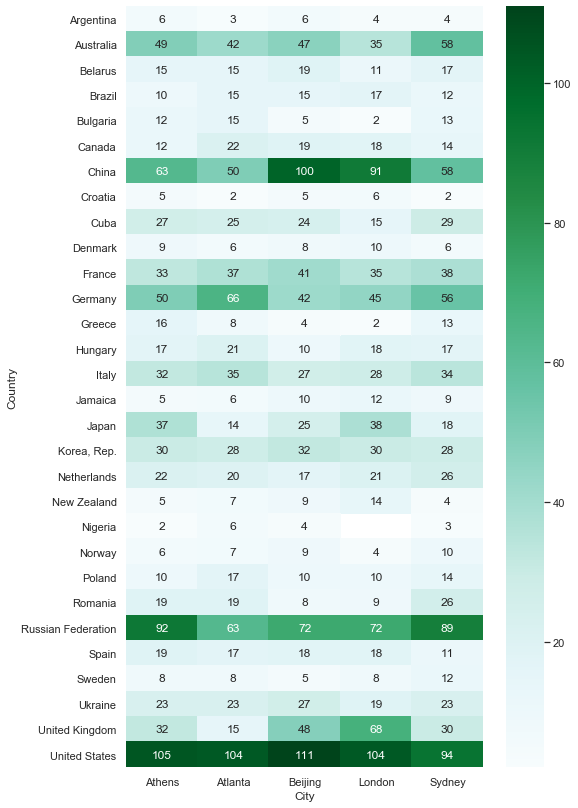

In [603]:
medals_by_country = pd.pivot_table(data = summeroly, index = "Country", columns = ["City"], values = "Medal", aggfunc = "count")
plt.figure(figsize = (8, 14))
sns.heatmap(medals_by_country, cmap = "BuGn", annot = True, fmt = ".0f")

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Beijing')]

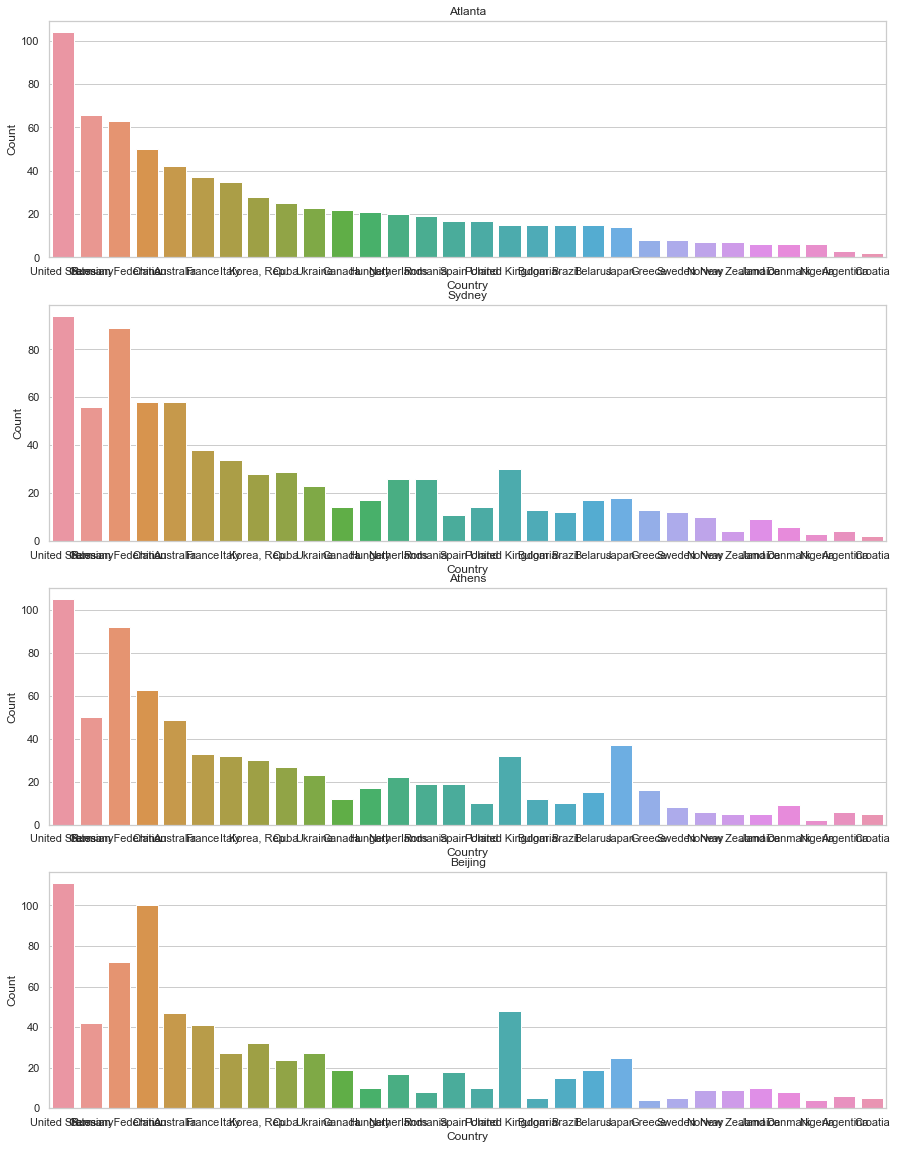

In [614]:
fig, axes = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(15, 20)
sns.set_style("whitegrid")

sns.barplot(data=all_medals,y="Atlanta", x = "Country", ax=axes[0])
sns.barplot(data=all_medals,y="Sydney",x="Country",orient="v",ax=axes[1])
sns.barplot(data=all_medals,y="Athens",x="Country",orient="v",ax=axes[2])
sns.barplot(data=all_medals,y="Beijing",x="Country",orient="v",ax=axes[3])

axes[0].set(ylabel='Count',title="Atlanta")
axes[1].set(ylabel='Count',title="Sydney")
axes[2].set(ylabel='Count',title="Athens")
axes[3].set(ylabel='Count',title="Beijing")

#### 개최국으로 선정되면 메달수에 영향이 있을까?

#### gdp에 따른 메달수는?

#### 인구수에 따른 메달수는?

#### 개최국과 출신국가의 온도차가 메달수에 영향을 미칠까?

#### 국가별로 메달확보가 쉬운 특정종목이 있을까?

#### 정치체제?!